# Animal Image Classification using CNN

This notebook demonstrates how to build a Convolutional Neural Network (CNN) to classify animal images. The dataset, containing 10 animal categories, is sourced from Kaggle (Animals10 dataset).

The dataset consist of about 28K medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.


### Objectives:
- Download data from Kaggle
- Preprocess and prepare image data
- Build and train a CNN model using TensorFlow/Keras
- Evaluate and visualize performance
- Analyze misclassified samples

This serves as a complete image classification pipeline using deep learning.


Importing all the necessary libararies


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
!pip install torch torchvision


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 362, in run
    resolver = self.make_resolver(
               ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 177, in make_resolver
    return pip._internal.resolution.resolvelib.resolver.Resolver(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 58, in __init__
    self.factory = Factory(
                   ^^^^^^^^
  File "/usr/local/lib/py

Download data from Kaggel

In [3]:
import kagglehub    ## Import the kagglehub library to interact with Kaggle datasets

# Download the latest version of the 'animals10' dataset from Kaggle
# The dataset is identified by the user 'alessiocorrado99' and the dataset name 'animals10'
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)   ## Print the local file path where the downloaded dataset is stored

Path to dataset files: /kaggle/input/animals10


In [4]:
from torchvision import datasets, transforms    ## Import datasets and transforms modules from torchvision
from torch.utils.data import DataLoader   ## Import DataLoader to create iterable over the dataset


# Define a sequence of transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),    ## Resize all images to 128x128 pixels
    transforms.ToTensor()   ## Convert images to PyTorch tensors (and scale pixel values to [0,1])
])

## Load dataset from the specified folder; expects subfolders as class labels
# Applies the transformations defined above to each image
dataset = datasets.ImageFolder("/kaggle/input/animals10", transform=transform)

# Create a DataLoader to iterate over the dataset in batches of 32, shuffling the data each epoch
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

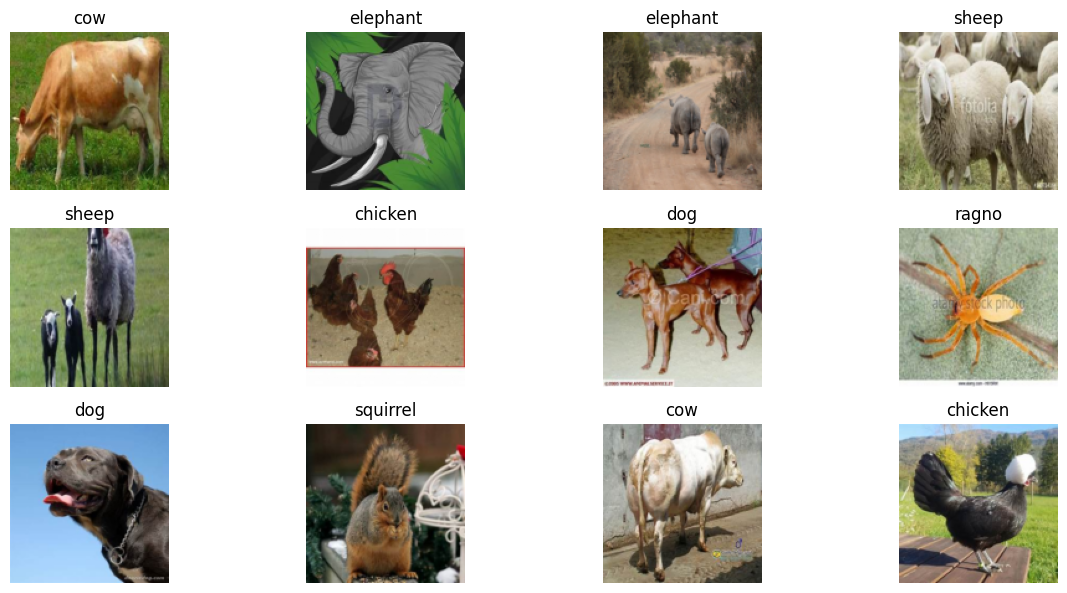

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Translation dictionary: Italian → English
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel"
}

# Rebuild dataset pointing to correct folder (adjust if needed)
dataset = datasets.ImageFolder("/kaggle/input/animals10/raw-img", transform=transform)

# Build mapping: label index → English class name
idx_to_english = {
    idx: translate.get(class_name, class_name)
    for class_name, idx in dataset.class_to_idx.items()
}

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Get one batch
images, labels = next(iter(data_loader))

# Plot
plt.figure(figsize=(12, 8))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(idx_to_english[labels[i].item()])  # Convert tensor to int
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Image parameters
img_size = (28, 28)  # Change this if you're not working with MNIST-style images
batch_size = 32

# Load dataset from folders (no batching so we get individual images)
dataset_path = "/kaggle/input/animals10/raw-img"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=img_size,
    batch_size=None,  # yields (image, label) per step
    shuffle=True
)

# Convert to NumPy arrays
x = []
y = []
for img, label in dataset:
    x.append(img.numpy())
    y.append(label.numpy())

# Fix indentation: convert after the loop
x = np.array(x)
y = np.array(y)

print("x shape:", x.shape)  # (num_samples, height, width, channels)
print("y shape:", y.shape)  # (num_samples,)

# Normalize pixel values
x = x / 255.0

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)


Found 26179 files belonging to 10 classes.
x shape: (26179, 28, 28, 3)
y shape: (26179,)
Train: (20943, 28, 28, 3) (20943,)
Test: (5236, 28, 28, 3) (5236,)


One hot encoding of labels

In [7]:
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


Model Initialization

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers  # To access layers more cleanly

# Define the number of output classes (e.g., 10 for Animals10 dataset or CIFAR-10)
num_classes = 10  # Set this to match your dataset

# Build the CNN model
model = Sequential([

    # Input layer specifying the shape of each image (28x28 RGB image)
    layers.Input(shape=(28, 28, 3)),

    # First convolutional block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),  # 32 filters with 3x3 kernel
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),                     # Reduce spatial dimensions by 2
    layers.Dropout(0.2),                                       # Dropout to reduce overfitting

    # Second convolutional block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # 64 filters
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),                     # Pooling layer
    layers.Dropout(0.35),                                       # Dropout again

    #Third convolutional block - Removed MaxPooling to prevent size issues
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),


   # Fully connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Increased from 128
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),  # Additional dense layer
    layers.Dropout(0.5),


    # Output layer with softmax activation for classification
    layers.Dense(num_classes, activation='softmax')
])


Model Compilation

In [53]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,354 (5.06 MB)

 Trainable params: 1,323,882 (5.05 MB)

 Non-trainable params: 1,472 (5.75 KB)

Data Augmentation+Model Training with it

In [54]:
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate images randomly
    width_shift_range=0.2,   # Shift horizontally
    height_shift_range=0.2,  # Shift vertically
    horizontal_flip=True,    # Flip images horizontally
    zoom_range=0.2,          # Random zoom
    shear_range=0.2,         # Shear transformation
    fill_mode='nearest'      # Fill missing pixels
)

# Fit the data generator on training data
datagen.fit(x_train)

# 4. TRAINING WITH AUGMENTED DATA (NO CALLBACKS)
history = model.fit(
    datagen.flow(x_train, y_train_cat, batch_size=32),
    steps_per_epoch=len(x_train) // 32,
    epochs=50,  # Reduced epochs since no early stopping
    validation_data=(x_test, y_test_cat),
    verbose=1
)


Epoch 1/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.1688 - loss: 3.1659 - val_accuracy: 0.1856 - val_loss: 2.1979
Epoch 2/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2188 - loss: 2.3855 - val_accuracy: 0.1877 - val_loss: 2.1996
Epoch 3/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.1884 - loss: 2.2084 - val_accuracy: 0.1965 - val_loss: 2.2012
Epoch 4/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2500 - loss: 2.1240 - val_accuracy: 0.1967 - val_loss: 2.2003
Epoch 5/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.1885 - loss: 2.2112 - val_accuracy: 0.1927 - val_loss: 2.2066
Epoch 6/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1562 - loss: 2.3493 - val_accuracy: 0.1927 - val_loss: 2.2066
Epoch 7/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.1895 - loss: 2.2064 - val_accuracy: 0.1927 - val_loss: 2.2061
Epoch 8/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1250 - loss: 2.2955 - val_accu

KeyboardInterrupt: 

Model Training

In [26]:
#history = model.fit(
#    x_train, y_train_cat,
#    epochs=50, batch_size=32,
#   validation_data=(x_test, y_test_cat)
#    )


Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2296 - loss: 2.1404 - val_accuracy: 0.3803 - val_loss: 1.7672
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3870 - loss: 1.7702 - val_accuracy: 0.4694 - val_loss: 1.5650
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4440 - loss: 1.6090 - val_accuracy: 0.4989 - val_loss: 1.4848
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4672 - loss: 1.5505 - val_accuracy: 0.5288 - val_loss: 1.3917
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4993 - loss: 1.4578 - val_accuracy: 0.5313 - val_loss: 1.3652
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5034 - loss: 1.4376 - val_accuracy: 0.5409 - val_loss: 1.3217
Epoch 7/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5251 - loss: 1.3853 - val_accuracy: 0.5558 - val_loss: 1.3254
Epoch 8/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5458 - loss: 1.3340 - va

KeyboardInterrupt: 

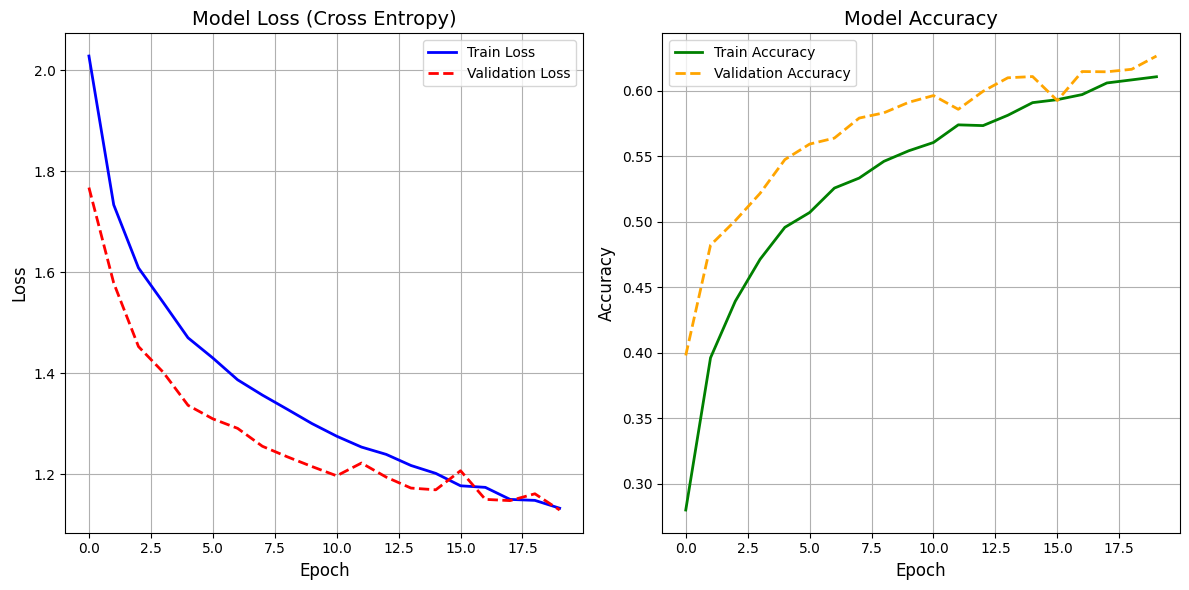

In [11]:
import matplotlib.pyplot as plt

# Set figure size and layout
plt.figure(figsize=(12, 6))

# --- Loss plot ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)
plt.title('Model Loss (Cross Entropy)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# --- Accuracy plot ---
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Final layout
plt.tight_layout()
plt.show()

Evaluation

In [12]:
test_loss,test_acc = model.evaluate(x_test, y_test_cat)
y_test_predict = model.predict(x_test)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6218 - loss: 1.1525
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Model Predicton

In [13]:
import numpy as np

y_pred_probs = model.predict(x_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


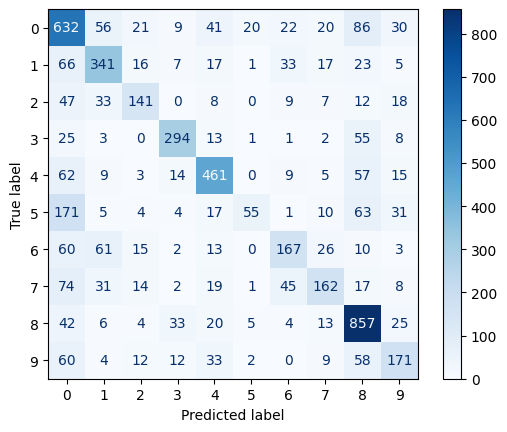

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

 Classification Report

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.67      0.58       937
           1       0.62      0.65      0.63       526
           2       0.61      0.51      0.56       275
           3       0.78      0.73      0.75       402
           4       0.72      0.73      0.72       635
           5       0.65      0.15      0.25       361
           6       0.57      0.47      0.52       357
           7       0.60      0.43      0.50       373
           8       0.69      0.85      0.76      1009
           9       0.54      0.47      0.51       361

    accuracy                           0.63      5236
   macro avg       0.63      0.57      0.58      5236
weighted avg       0.63      0.63      0.61      5236



 Visualize Misclassified Samples

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


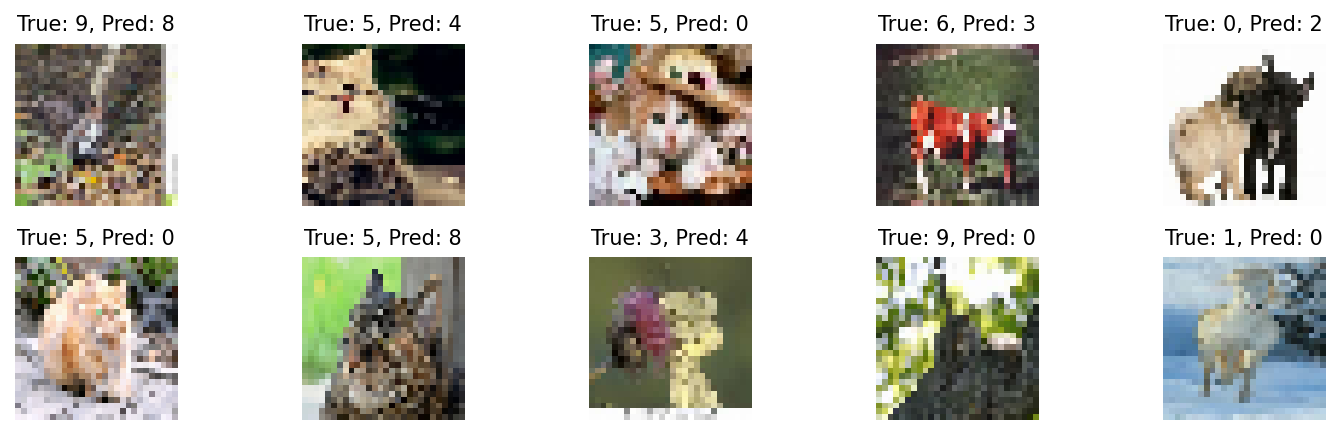

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Predict and identify misclassified samples
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Plot first 10 misclassified color images clearly
plt.figure(figsize=(10, 3), dpi=150)  # Higher DPI for sharpness

for i, idx in enumerate(misclassified_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx], interpolation='none')  # <– Critical: no blur
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_classes[idx]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
